## inference in simple model using synthetic data
population size 10^6, inference window 2x4 = 8 days, to be compared with ``-win5`` analogous notebook 

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
import os
import pickle
import pprint
import time

import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

import synth_fns

(cell 3 was removed to hide local file info)
### main settings

In [4]:
## for dataFiles : needs a fresh value in every notebook
fileRoot = 'dataSynthInfTest-pop1e6-win2'

## total population
popN = 1e6

## tau-leaping param, take this negative to force gillespie
## or set a small value for high-accuracy tau-leap (eg 1e-4 or 1e-5)
leapEps = -1

## do we use small tolerances for the likelihood computations? (use False for debug etc)
isHighAccuracy = True

# absolute tolerance for logp for MAP 
inf_atol = 1.0

## prior mean of beta, divided by true value (set to 1.0 for the simplest case)
betaPriorOffset = 0.8
betaPriorLogNorm = False

## mcmc
mcSamples = 5000
nProcMCMC = 2 # None ## take None to use default but large numbers are not efficient in this example

In [5]:
trajSeed = 18
infSeed = 21
mcSeed = infSeed+2

loadTraj = False
saveMC = True

### model

In [6]:
model_dict = synth_fns.get_model(popN)

model_spec = model_dict['mod']
contactMatrix = model_dict['CM']
parameters_true = model_dict['params']
cohortsM = model_dict['cohortsM']
Ni = model_dict['cohortsPop']

#### more settings

In [7]:
## total trajectory time (bare units)
Tf_bare = 20
## total inf time
Tf_inf_bare = 2

## inference period starts when the total deaths reach this amount (as a fraction)
fracDeaths = 2e-3 # int(N*200/1e5)


In [8]:
## hack to get higher-frequency data
## how many data points per "timestep" (in original units)
fineData = 4

## this assumes that all parameters are rates !!
for key in parameters_true:
    #print(key,parameters_true[key])
    parameters_true[key] /= fineData

Tf = Tf_bare * fineData;  
Nf = Tf+1

Tf_inference = Tf_inf_bare * fineData
Nf_inference = Tf_inference+1

### plotting helper functions

In [9]:
def plotTraj(M,data_array,Nf_start,Tf_inference,fineData):
    fig = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    # plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    plt.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(1,2, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = axs[0]
    ax.plot(t[1:],np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)),'o-',label='death increments', lw=1)
    ax.legend(loc='upper right') ; # plt.show()

    ax = axs[1]
    ax.plot(t,np.sum(data_array[:, 3*M:4*M], axis=1),'o-',label='deaths',ms=3)
    ax.legend() ; 

    plt.show()


def plotMAP(res,data_array,M,N,estimator,Nf_start,Tf_inference,fineData):
    print('**beta(bare units)',res['params_dict']['beta']*fineData)
    print('**logLik',res['log_likelihood'],'true was',logpTrue)
    print('\n')
    print(res)

    fig,axs = plt.subplots(1,3, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(wspace=0.3)
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    ax = axs[0]

    #plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    ax.plot(t, np.sum(data_array[:, M:2*M], axis=1), 'o', label='Exposed', lw=2)
    ax.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), 'o', label='Infected', lw=2)
    ax.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), 'o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    #plt.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', color='C0',label='E-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', color='C1',label='I-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', color='C2',label='D-MAP', lw=2, ms=3)
    #plt.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-o', label='R-MAP', lw=2)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[1]
    ax.plot(t[1:], np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)), '-o', label='death incs', lw=2)
    ax.plot(tt[1:], np.diff(np.sum(xm[:, 3*M:4*M], axis=1)), '-x', label='MAP', lw=2, ms=3)
    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[2]

    ax.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='Sus', lw=1.5, ms=3)
    #plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    #plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    #plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    ax.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=1.5, ms=3)

    #infResult = res
    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    ax.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', label='E-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', label='I-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', label='D-MAP', lw=2, ms=3)
    ax.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-x', label='R-MAP', lw=1.5, ms=3)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()
    plt.show()
    

    
def plotMCtrace(selected_dims, sampler, numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()

def plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit) :
    ## used for prior pdfs
    (likFun,priFun,dimFlat) = pyross.evidence.latent_get_parameters(estimator,
                                        obsData, fltrDeath, Tf_inference,
                                        param_priors, init_priors,                                   
                                        contactMatrix,
                                        #intervention_fun=interventionFn,
                                        tangent=False,
                                      )
    xVals = np.linspace(parameters_true['beta']*0.5,parameters_true['beta']*1.5,100)

    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    plt.hist(betas,density=True,color='lightblue',label='posterior')
    yVal=2
    plt.plot([infResult['params_dict']['beta']],[2*yVal],'bs',label='MAP',ms=10)
    plt.plot([parameters_true['beta']],[yVal],'ro',label='true',ms=10)


    ## this is a bit complicated, it just finds the prior for beta from the infResult
    var='beta'
    jj = infResult['param_keys'].index(var)
    xInd = infResult['param_guess_range'][jj]
    #print(jj,xInd)
    pVals = []
    for xx in xVals :
        flatP = np.zeros( dimFlat )
        flatP[xInd] = xx
        pdfAll = np.exp( priFun.logpdf(flatP) )
        pVals.append( pdfAll[xInd] )
    plt.plot(xVals,pVals,color='darkgreen',label='prior')


    plt.xlabel(var)
    plt.ylabel('pdf')
    plt.legend()

    labs=['init S','init E','init I']
    nPanel=3
    fig,axs = plt.subplots(1,nPanel,figsize=(14,4))
    for ii in range(nPanel) :   
        ax = axs[ii]
        yVal=1.0/popN
        xs = [ rr['x0'][ii] for rr in result_mcmc ]
        ax.hist(xs,color='lightblue',density=True)
        ax.plot([infResult['x0'][ii]],yVal,'bs',label='true')
        ax.plot([trueInit[ii]],yVal,'ro',label='true')


        ## this is a bit complicated, it just finds the prior for beta from the infResult
        ## axis ranges
        xMin = np.min(xs)*0.8
        xMax = np.max(xs)*1.2
        xVals = np.linspace(xMin,xMax,100)

        ## this ID is a negative number because the init params are the end of the 'flat' param array
        paramID = ii-nPanel 
        pVals = []
        for xx in xVals :
            flatP = np.zeros( dimFlat )
            flatP[paramID] = xx
            pdfAll = np.exp( priFun.logpdf(flatP) )
            pVals.append( pdfAll[paramID] )
        ax.plot(xVals,pVals,color='darkgreen',label='prior')

        #plt.xlabel(var)
        ax.set_xlabel(labs[ii])
        ax.set_ylabel('pdf')
        ax.yaxis.set_ticklabels([])

    plt.show()


### synthetic data

In [10]:
if loadTraj :
    ipFile = fileRoot+'-stochTraj.npy'
    syntheticData = np.load(ipFile)
    print('loading trajectory from',ipFile)
else :
    ticTime = time.time()
    syntheticData = synth_fns.make_stochastic_traj(Tf,Nf,trajSeed,model_dict,leapEps)
    tocTime = time.time() - ticTime
    print('traj generation time',tocTime,'secs')

np.save(fileRoot+'-stochTraj.npy',syntheticData)

Nf_start = synth_fns.get_start_time(syntheticData, popN, fracDeaths)
print('inf starts at timePoint',Nf_start)

{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 18}
traj generation time 41.87377667427063 secs
inf starts at timePoint 27


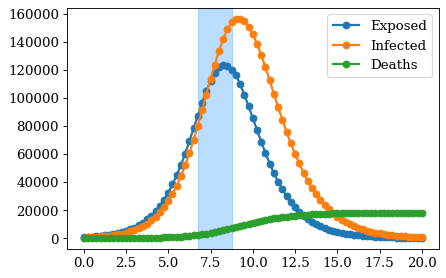

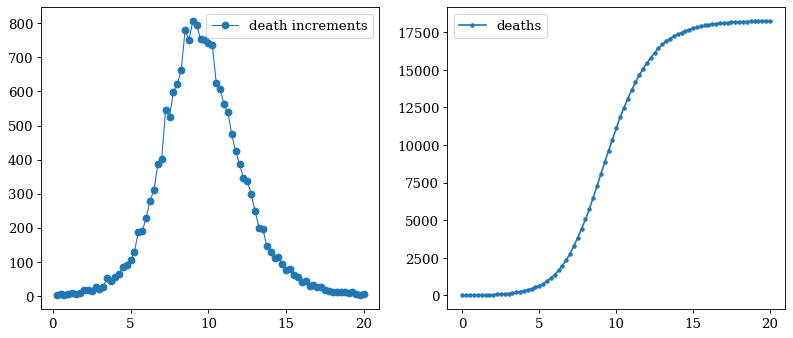

In [11]:
plotTraj(cohortsM,syntheticData,Nf_start,Tf_inference,fineData)

### basic inference (estimator) setup
(including computation of likelihood for the true parameters)

In [12]:
[estimator,fltrDeath,obsData,trueInit] = synth_fns.get_estimator(isHighAccuracy,model_dict,syntheticData, popN, Nf_start, Nf_inference,)

## compute log-likelihood of true params
logpTrue = -estimator.minus_logp_red(parameters_true, trueInit, obsData, fltrDeath, Tf_inference, 
                                     contactMatrix, tangent=False)
print('**logLikTrue',logpTrue,'\n')

print('death data\n',obsData,'length',np.size(obsData),Nf_inference)

setting high-accuracy for likelihood
**logLikTrue -40.72311526408154 

death data
 [[2365.]
 [2767.]
 [3313.]
 [3839.]
 [4438.]
 [5060.]
 [5722.]
 [6501.]
 [7253.]] length 9 9


### priors

In [13]:
[param_priors,init_priors] = synth_fns.get_priors(model_dict,betaPriorOffset,betaPriorLogNorm,fracDeaths,estimator)
print('Prior Params:',param_priors)
print('Prior Inits:')
pprint.pprint(init_priors)
print('trueBeta',parameters_true['beta'])
print('trueInit',trueInit)

Prior Params: {'beta': {'mean': 0.028000000000000004, 'std': 0.014000000000000002, 'bounds': [0.0001, 0.14], 'prior_fun': 'truncnorm'}}
Prior Inits:
{'independent': {'bounds': [[72000.0, 1000000.0],
                            [10100.251257867601, 1010025.12578676],
                            [7899.748742132397, 789974.8742132396]],
                 'fltr': array([ True,  True,  True, False]),
                 'mean': array([720000.        , 101002.51257868,  78997.48742132]),
                 'prior_fun': 'truncnorm',
                 'std': array([33667.50419289, 33667.50419289, 26332.49580711])}}
trueBeta 0.035
trueInit [709875.  87267.  80333.   2365.]


### inference (MAP)

In [14]:
infResult = synth_fns.do_inf(estimator, obsData, fltrDeath, syntheticData, 
                             popN, Tf_inference, infSeed, param_priors,init_priors, model_dict, inf_atol)

Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=21, Sat May  1 13:03:38 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 7.704383942908420e+01 1.0e+00 1.00e+00  1e-02  3e+04 0:01.6
    2    128 7.252563298872531e+01 1.8e+00 9.68e-01  9e-03  4e+04 0:03.1
    3    192 7.163917093426959e+01 3.1e+00 8.23e-01  6e-03  3e+04 0:04.7
    5    320 7.096383466301374e+01 7.6e+00 6.61e-01  3e-03  2e+04 0:07.8
    8    512 7.090657777596969e+01 1.6e+01 6.43e-01  2e-03  1e+04 0:12.5
   12    768 7.080727508881648e+01 2.2e+01 4.26e-01  3e-04  3e+03 0:18.7
   15    960 7.080598224196227e+01 2.0e+01 3.49e-01  1e-04  1e+03 0:23.4
Optimal value (global minimisation):  70.80598224196227
Starting local minimisation...
Optimal value (local minimisation):  70.80582259847648


In [15]:
#pprint.pprint(infResult)
print('MAP likelihood',infResult['log_likelihood'],'true',logpTrue)
print('MAP beta',infResult['params_dict']['beta'],'true',parameters_true['beta'])

MAP likelihood -40.347160920804455 true -40.72311526408154
MAP beta 0.03188011492363837 true 0.035


### plot MAP trajectory

**beta(bare units) 0.12752045969455347
**logLik -40.347160920804455 true was -40.72311526408154


{'params_dict': {'beta': 0.03188011492363837, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 18}, 'x0': array([725209.60575166, 101859.7992907 ,  76606.06026326,   2365.        ]), 'flat_params': array([3.18801149e-02, 7.25209606e+05, 1.01859799e+05, 7.66060603e+04]), 'log_posterior': -70.80582259847648, 'log_prior': -30.458661677672026, 'log_likelihood': -40.347160920804455, 'param_keys': ['beta'], 'param_guess_range': [0], 'is_scale_parameter': [False], 'param_length': 1, 'scaled_param_guesses': [], 'init_flags': [False, True], 'init_fltrs': [None, array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])], 'prior': <pyross.utils_python.Prior object at 0x7f612484fe50>}


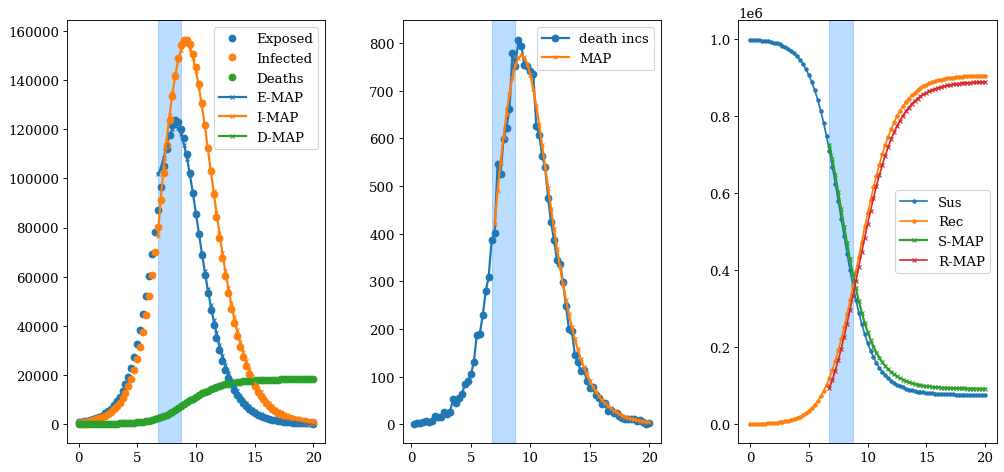

In [16]:
plotMAP(infResult,syntheticData,cohortsM,popN,estimator,Nf_start,Tf_inference,fineData)

#### slice of likelihood 
(note this is not the posterior, hence MAP is not exactly at the peak)

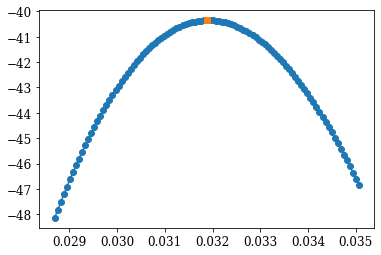

In [17]:
## range for beta (relative to MAP)
rangeParam = 0.1
[bVals,likVals] = synth_fns.sliceLikelihood(rangeParam,infResult,
                                            estimator,obsData,fltrDeath,contactMatrix,Tf_inference)

#print('logLiks',likVals,logp)
plt.plot(bVals , likVals, 'o-')
plt.plot(infResult['params_dict']['beta'],infResult['log_likelihood'],'s',ms=6)
plt.show()

### MCMC

In [18]:
sampler = synth_fns.do_mcmc(mcSamples, nProcMCMC, estimator, Tf_inference, infResult, 
                            obsData, fltrDeath, param_priors, init_priors, 
                            model_dict,infSeed)

est map [3.18801149e-02 7.25209606e+05 1.01859799e+05 7.66060603e+04] 4


100%|██████████| 5000/5000 [30:55<00:00,  2.69it/s]


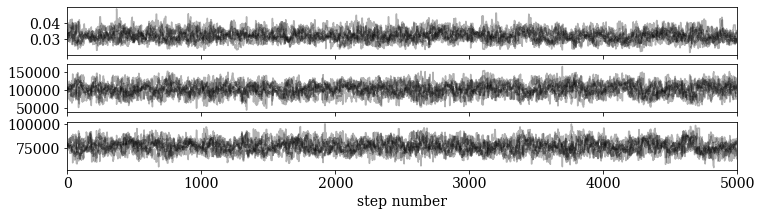

result shape (528,)
last sample
 {'params_dict': {'beta': 0.029538135912936823, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 18}, 'x0': array([733476.13032768, 117858.90349131,  73918.47874949,   2365.        ]), 'flat_params': array([2.95381359e-02, 7.33476130e+05, 1.17858903e+05, 7.39184787e+04]), 'log_posterior': -72.21516277561061, 'log_prior': -30.633917166363858, 'log_likelihood': -41.58124560924675, 'weight': 0.001893939393939394, 'param_keys': ['beta'], 'param_guess_range': [0], 'is_scale_parameter': [False], 'param_length': 1, 'scaled_param_guesses': [], 'init_flags': [False, True], 'init_fltrs': [None, array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])], 'prior': <pyross.utils_python.Prior object at 0x7f61248fd850>}


In [19]:
plotMCtrace([0,2,3], sampler)
result_mcmc = synth_fns.load_mcmc_result(estimator, obsData, fltrDeath, sampler, param_priors, init_priors, model_dict)

print('result shape',np.shape(result_mcmc))
print('last sample\n',result_mcmc[-1])

#### save the result

In [20]:
if saveMC :
    opFile = fileRoot + "-mcmc.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        pickle.dump([infResult,result_mcmc],f)

opf dataSynthInfTest-pop1e6-win2-mcmc.pik


#### estimate MCMC autocorrelation

In [21]:
# these are the estimated autocorrelation times for the sampler
# (it likes runs ~50 times longer than this...)
pp = sampler.get_log_prob()
nSampleTot = np.shape(pp)[0]
#print('correl',sampler.get_autocorr_time(discard=int(nSampleTot/3)))
print('nSampleTot',nSampleTot)

nSampleTot 5000


#### plot posterior distributions

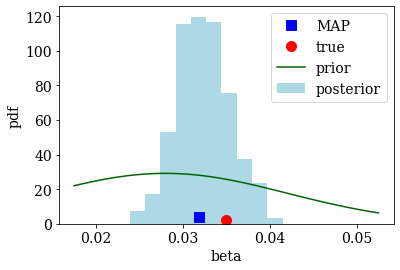

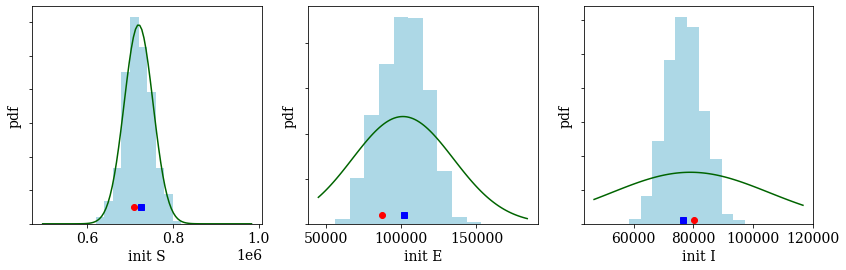

In [22]:
plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit)


### analyse posterior for beta

In [23]:
betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
postMeanBeta = np.mean(betas)
postStdBeta = np.std(betas)
postCIBeta = [ np.percentile(betas,2.5) , np.percentile(betas,97.5)]

print("beta: true {b:.5f} MAP {m:.5f}".format(b=parameters_true['beta'],m=infResult['params_dict']['beta']))
print("post: mean {m:.5f} std {s:.5f} CI95: {l:.5f} {u:.5f}".format(m=postMeanBeta,
                                                                 s=postStdBeta,
                                                                 l=postCIBeta[0],u=postCIBeta[1]))



beta: true 0.03500 MAP 0.03188
post: mean 0.03242 std 0.00305 CI95: 0.02698 0.03879


###  posterior correlations for initial conditions

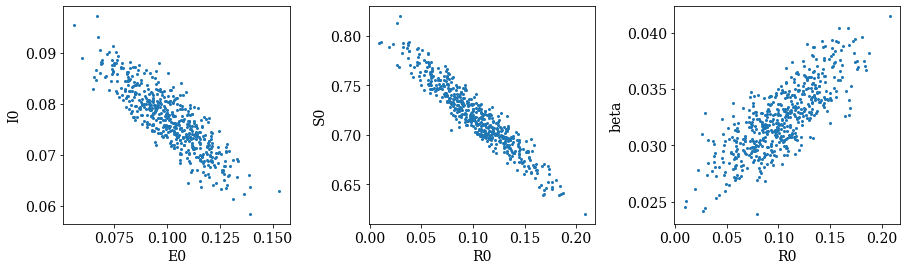

In [24]:
sis = np.array( [ rr['x0'][0] for rr in result_mcmc ] )/popN
eis = np.array( [ rr['x0'][1] for rr in result_mcmc ] )/popN
iis = np.array( [ rr['x0'][2] for rr in result_mcmc ] )/popN
betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]

fig,axs = plt.subplots(1,3,figsize=(15,4))
plt.subplots_adjust(wspace=0.35)

ax = axs[0]

ax.plot(eis,iis,'o',ms=2)
ax.set_xlabel('E0')
ax.set_ylabel('I0')

ax = axs[1]

ax.plot(1-eis-iis-sis,sis,'o',ms=2)
ax.set_ylabel('S0')
ax.set_xlabel('R0')

ax = axs[2]
ax.plot(1-eis-iis-sis,betas,'o',ms=2)
ax.set_ylabel('beta')
ax.set_xlabel('R0')

plt.show()

In [38]:
def forecast(result_mcmc, nsamples, Nf_start, Tf_inference, Nf_inference, estimator, obs, fltr, contactMatrix):
    trajs = []
    #x = (data_array[Nf_start:Nf_start+Nf_inference])
    #obs=np.einsum('ij,kj->ki', fltr, x)

    # this should pick up the right number of traj, equally spaced
    totSamples = len(result_mcmc)
    skip = int(totSamples/nsamples)
    modulo = totSamples % skip
    #print(modulo,skip)
    
    for sample_res in result_mcmc[modulo::skip]: 
        endpoints = estimator.sample_endpoints(obs, fltr, Tf_inference, sample_res, 1, contactMatrix=contactMatrix)
        xm = estimator.integrate(endpoints[0], Nf_start+Tf_inference, Tf, Nf-Tf_inference-Nf_start, dense_output=False)
        trajs.append(xm)

    return trajs 

def plot_forecast(allTraj, data_array, nsamples,  Tf,Nf, Nf_start, Tf_inference, Nf_inference, M,
                  estimator, obs,  contactMatrix):
    #x = (data_array[Tf_start:Tf_start+Nf_inference]).astype('float') 
    #obs=np.einsum('ij,kj->ki', fltr, x)
    
    #samples = estimator.sample_endpoints(obs, fltr, Tf_inference, res, nsamples, contactMatrix=contactMatrix)
    time_points = np.linspace(0, Tf, Nf)

    fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    #for x_start in samples: 
    for traj in allTraj: 
        #xm = estimator.integrate(x_start, Tf_start+Tf_inference, Tf, Nf-Tf_inference-Tf_start, dense_output=False)
    #     plt.plot(time_points[Tf_inference+Tf_start:], np.sum(xm[:, M:2*M], axis=1), color='grey', alpha=0.1)
    #     plt.plot(time_points[Tf_inference+Tf_start:], np.sum(xm[:, 2*M:3*M], axis=1), color='grey', alpha=0.1)
        
        incDeaths = np.diff( np.sum(traj[:, 3*M:4*M], axis=1) )
        
        plt.plot(time_points[1+Tf_inference+Nf_start:], incDeaths, color='grey', alpha=0.2)

    # plt.plot(time_points, np.sum(data_array[:, M:2*M], axis=1), label='True E')
    # plt.plot(time_points, np.sum(data_array[:, 2*M:3*M], axis=1), label='True I')
    
    incDeathsObs = np.diff( np.sum(data_array[:, 3*M:4*M], axis=1) )

    plt.plot(time_points[1:],incDeathsObs, 'ko', label='True D')
    plt.axvspan(Nf_start, Tf_inference+Nf_start, 
               label='Used for inference',
               alpha=0.3, color='dodgerblue')
    plt.xlim([0, Tf])
    plt.legend() 
    plt.show()

In [45]:
nsamples = 40
foreTraj = forecast(result_mcmc, nsamples, Nf_start, Tf_inference, Nf_inference, 
                    estimator, obsData, fltrDeath, contactMatrix)
print(len(foreTraj))

foreTraj = np.array( foreTraj )
np.save(fileRoot+'-foreTraj.npy',foreTraj)

40


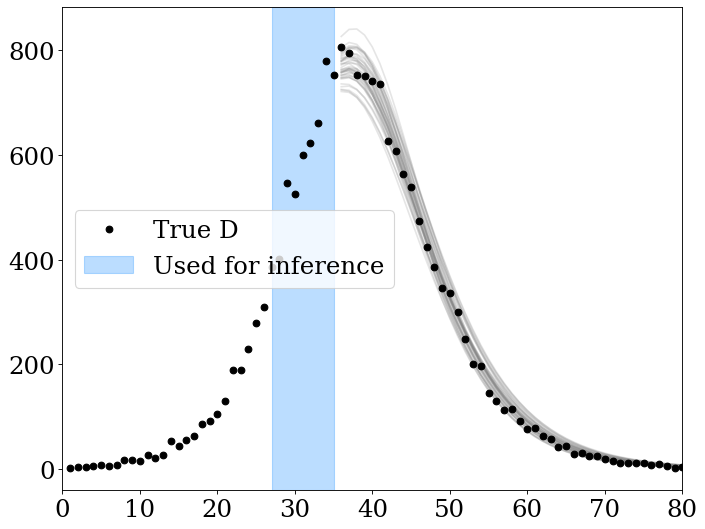

In [40]:
plot_forecast(foreTraj, syntheticData, nsamples,  Tf,Nf, Nf_start, Tf_inference, Nf_inference, cohortsM,
              estimator, obsData, contactMatrix)

In [46]:
print(Nf_inference)

9


In [47]:
print(len(result_mcmc))

528
